In [102]:
svtype <- 'DEL'
sample <- 'HTZ-SV'
truth_set_file <- '../../../../data/test/htz-sv.vcf'
regions_for_filtering <- '../../../../data/test/ENCFF001TDO.bed'
out_dir <- 'results'

In [103]:
# SV callsets
callsets <- list()
# callsets[['CNN']]  <- 'CNN_predictions.bedpe'
callsets[['GRIDSS']] <- '../../../../data/test/vcf/gridss_out/gridss.vcf'
callsets[['Manta']] <- '../../../../data/test/vcf/manta_out/manta.vcf'
callsets[['Lumpy']] <- '../../../../data/test/vcf/lumpy_out/lumpy.vcf'
callsets[['DELLY']] <- '../../../../data/test/vcf/delly_out/delly.vcf'

Load the [StructuralVariantAnnotation](https://bioconductor.org/packages/devel/bioc/vignettes/StructuralVariantAnnotation/inst/doc/vignettes.html) package

In [104]:
suppressPackageStartupMessages(require(StructuralVariantAnnotation))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(ggplot2))

[SV type inference](https://github.com/PapenfussLab/gridss/blob/7b1fedfed32af9e03ed5c6863d368a821a4c699f/example/simple-event-annotation.R#L9)

In [105]:
infer_svtype <- function(gr)
{
  gr$svtype <-
    ifelse(
      seqnames(gr) != seqnames(partner(gr)),
      "TRA", # Using TRA instead of ITX or BP
      ifelse(
        gr$insLen >= abs(gr$svLen) * 0.7,
        "INS",
        ifelse(
          strand(gr) == strand(partner(gr)),
          "INV",
          ifelse(xor(
            start(gr) < start(partner(gr)), strand(gr) == "-"
          ), "DEL",
          "DUP")
        )
      )
    )
  return(gr)
}

In [106]:
load_bed <- function(bed_file)
{
    bed_regions <- rtracklayer::import(bed_file)
    # set NCBI seqlevels
    seqlevelsStyle(bed_regions) <- "NCBI"
    return(bed_regions)
}

In [107]:
load_bedpe <- function(bedpe_file, filter_regions)
{
  bedpe_gr <- pairs2breakpointgr(rtracklayer::import(bedpe_file))
  bedpe_gr <- filter_regions(bedpe_gr, load_bed(filter_regions), mode='remove')
  return(bedpe_gr)
}

In [108]:
load_vcf <- function(vcf_file, svtype, caller, filter_regions)
{
    # Load VCF file
    vcf_gr <-
      VariantAnnotation::readVcf(vcf_file)
    
    # set NCBI seqlevels
    seqlevelsStyle(vcf_gr) <- 'NCBI'
    
    if(caller=='survivor')
    {
        # SURVIVOR simSV assigns LowQual to all artificial SVs
        vcf_gr <- vcf_gr[rowRanges(vcf_gr)$FILTER%in%c("LowQual")]
        
        # handle SURVIVOR simSV SVTYPE <TRA> as TIGRA <CTX>
        if("TRA" %in% info(vcf_gr)$SVTYPE & !("CT" %in% names(info(vcf_gr))))
        {
          info(vcf_gr)$SVTYPE[info(vcf_gr)$SVTYPE=="TRA"] <- "CTX"
        }

    }else{
        # Keep only SVs that passed the filtering (PASS or .)
        vcf_gr <- vcf_gr[rowRanges(vcf_gr)$FILTER%in%c("PASS",".")]
    }

    if (caller == 'lumpy')
    {
      # Read evidence support as a proxy for QUAL
      support <- unlist(info(vcf_gr)$SU)
      fixed(vcf_gr)$QUAL <- support
    } else if (caller == 'delly')
    {
      # Split-read support plus Paired-end read support as a proxy for QUAL
      sr_support <- info(vcf_gr)$SR
      sr_support[is.na(vcf_gr)] <- 0
      fixed(vcf_gr)$QUAL <-
        sr_support + info(vcf_gr)$PE
    }
    
    vcf_gr <- breakpointRanges(vcf_gr)
    vcf_gr <- infer_svtype(vcf_gr)
    
    # Select only one SV type
    vcf_gr <- vcf_gr[which(vcf_gr$svtype == svtype)]

    # Select SVs >= 50 bp
    vcf_gr <- vcf_gr[abs(vcf_gr$svLen) >= 50]
    
    #Filter regions
    vcf_gr <- filter_regions(vcf_gr, load_bed(filter_regions), mode='remove')
}

In [109]:
filter_regions <- function(regions_to_filter, ref_regions, mode='remove')
{
    print(length(regions_to_filter))
  if (mode == 'keep')
  {
    result <- regions_to_filter[overlapsAny(regions_to_filter, ref_regions) &
         overlapsAny(partner(regions_to_filter), ref_regions), ]
  } else{
    result <- regions_to_filter[!(
      overlapsAny(regions_to_filter, ref_regions) |
        overlapsAny(partner(regions_to_filter), ref_regions)
    ), ]
  }
    print(length(result))
    return(result)
}

Load the truth set

In [110]:
truth_set <- load_vcf(truth_set_file, 'DEL', 'survivor', regions_for_filtering)
# truth_set <- truth_set[truth_set$sourceId==svtype]
length(truth_set)

Warning message in .breakpointRanges(x, ...):
“Found 1000 duplicate row names (duplicates renamed).”

[1] 1964
[1] 1964


[1] 1964

Load the SV callsets

In [111]:
sv_regions <- list()
# sv_regions[['CNN']] <- load_bedpe(callsets[['CNN']], regions_for_filtering)
sv_regions[['GRIDSS']] <- load_vcf(callsets[['GRIDSS']], svtype, 'gridss', regions_for_filtering)
sv_regions[['Manta']] <- load_vcf(callsets[['Manta']], svtype, 'manta', regions_for_filtering)
sv_regions[['Lumpy']] <- load_vcf(callsets[['Lumpy']], svtype, 'lumpy', regions_for_filtering)
sv_regions[['DELLY']] <- load_vcf(callsets[['DELLY']], svtype, 'delly', regions_for_filtering)

Warning message in .breakpointRanges(x, ...):
“Removing 1 unpaired breakend variants gridss0_7528h”

[1] 1422
[1] 1422
[1] 1530
[1] 1530
[1] 2408
[1] 2408


Warning message in .breakpointRanges(x, ...):
“Removing 2081 unpaired breakend variants BND00000002, BND00000000, BND00000003, BND00000006, BND00000007, BND00000005, BND00000008, BND00000010, BND00000011, BND00000013, BND00000012, BND00000015, BND00000014, BND00000017, BND00000016, BND00000019, BND00000018, BND00000020, BND00000022, BND00000024, BND00000025, BND00000026, BND00000029, BND00000027, BND00000031, BND00000030, BND00000034, BND00000036, BND00000037, BND00000038, BND00000035, BND00000039, BND00000040, BND00000041, BND00000043, BND00000042, BND00000045, BND00000044, BND00000046, BND00000048, BND00000047, BND00000051, BND00000049, BND00000053, BND00000052, BND00000050, BND00000055, BND00000056, BND00000054, BND00000058, BND00000057, BND00000060, BND00000061, BND00000063, BND00000062, BND00000064, BND00000066, BND00000065, BND00000068, BND00000069, BND00000067, BND00000071, BND00000070, BND00000073, BND00000072, BND00000074, BND00000075, BND00000076, BND00000078, BND00000077, BN

[1] 2512
[1] 2512


Add SV caller name

In [112]:
for (c in names(sv_regions))
{
  sv_regions[[c]]$caller <- c
}

In [113]:
seqlengths(truth_set) <- c("12" = 2000000, "22" = 2000000)
for (c in names(sv_regions))
{
seqlengths(sv_regions[[c]]) <- c("12" = 2000000, "22" = 2000000)
}

Compute overlap

In [114]:
for (c in names(sv_regions))
{
    
  sv_regions[[c]]$truth_matches <-
    countBreakpointOverlaps(
      sv_regions[[c]],
      truth_set,
      # read pair based callers make imprecise calls.
      # A margin around the call position is required when matching with the truth set
      maxgap = 200,
      # Since we added a maxgap, we also need to restrict the mismatch between the
      # size of the events. We don't want to match a 100bp deletion with a
      # 5bp duplication. This will happen if we have a 100bp margin but don't also
      # require an approximate size match as well
      sizemargin = 0.25,
      ignore.strand = TRUE,
      # We also don't want to match a 20bp deletion with a 20bp deletion 80bp away
      # by restricting the margin based on the size of the event, we can make sure
      # that simple events actually do overlap
      restrictMarginToSizeMultiple = 0.5,
      # Some callers make duplicate calls and will sometimes report a variant multiple
      # times with slightly different bounds. countOnlyBest prevents these being
      # double-counted as multiple true positives.
      countOnlyBest = TRUE
    )

}
    
sv_regions <- unlist(GRangesList(sv_regions))

In [115]:
sv_regions

GRanges object with 7872 ranges and 14 metadata columns:
                        seqnames          ranges strand | paramRangeID
                           <Rle>       <IRanges>  <Rle> |     <factor>
   GRIDSS.gridss0_1126o       12       1637-1638      + |         <NA>
   GRIDSS.gridss0_1126h       12       1947-1948      - |         <NA>
   GRIDSS.gridss0_1131o       12       3186-3190      + |         <NA>
   GRIDSS.gridss0_1131h       12       3572-3576      - |         <NA>
   GRIDSS.gridss0_1146o       12            7523      + |         <NA>
                    ...      ...             ...    ... .          ...
  DELLY.DEL00001294_bp2       22 1932315-1932317      - |         <NA>
  DELLY.DEL00001302_bp2       22 1969522-1969526      - |         <NA>
  DELLY.DEL00001303_bp2       22 1971555-1971557      - |         <NA>
  DELLY.DEL00001307_bp2       22 1979969-1979975      - |         <NA>
  DELLY.DEL00001309_bp2       22 1990138-1990142      - |         <NA>
                    

Plotting Precision and Recall as in [StructuralVariantAnnotation vignette](https://bioconductor.org/packages/devel/bioc/vignettes/StructuralVariantAnnotation/inst/doc/vignettes.html)

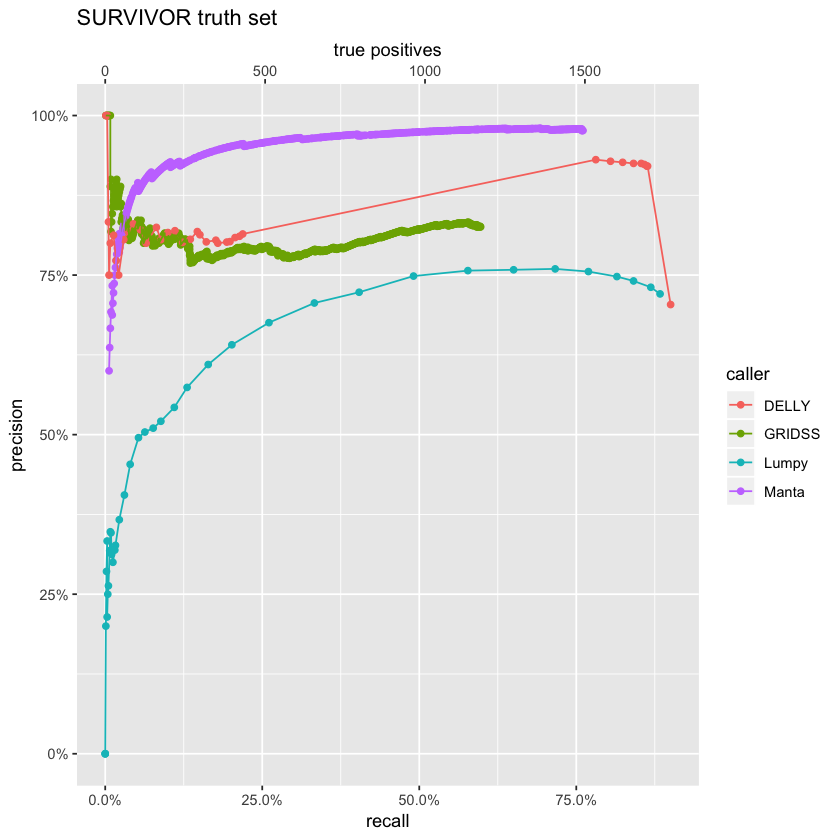

In [116]:
main.title <- c("SURVIVOR truth set")
names(main.title) <- c(sample)

ggplot(
  as.data.frame(sv_regions) %>%
    dplyr::select(QUAL, caller, truth_matches) %>%
    dplyr::group_by(caller, QUAL) %>%
    dplyr::summarise(calls = n(),
                     tp = sum(truth_matches > 0)) %>%
    dplyr::group_by(caller) %>%
    dplyr::arrange(dplyr::desc(QUAL)) %>%
    dplyr::mutate(
      cum_tp = cumsum(tp),
      cum_n = cumsum(calls),
      cum_fp = cum_n - cum_tp,
      precision = cum_tp / cum_n,
      recall = cum_tp / length(truth_set)
    )
) +
  aes(x = recall,
      y = precision,
      colour = caller) +
  geom_point() +
  geom_line() +
  scale_y_continuous(labels = scales::percent) +
  scale_x_continuous(
    labels = scales::percent,
    sec.axis = sec_axis( ~ (.) * length(truth_set), name = "true positives")
  ) +
  labs(title = main.title[sample])

In [117]:
make_percent <- function(x){
  signif(x*100,digits = 4)
}

Summarize results

In [119]:
res.df <- as.data.frame(sv_regions) %>%
    dplyr::select(caller, truth_matches) %>%
    dplyr::group_by(caller) %>%
    dplyr::summarise(calls = n(),
                   tp = sum(truth_matches > 0)) %>%
    dplyr::group_by(caller) %>%
    dplyr::mutate(
    cum_tp = cumsum(tp),
    cum_n = cumsum(calls),
    cum_fp = cum_n - cum_tp,
    precision = signif(cum_tp / cum_n, digits = 4),
    recall = signif(cum_tp / length(truth_set), digits = 4)
    )
res.df$F1 = with(res.df, 2 * (precision * recall) / (precision + recall))
res.df$precision <- make_percent(res.df$precision)
res.df$recall <- make_percent(res.df$recall)
res.df$F1 <- make_percent(res.df$F1)

In [120]:
res.df

caller,calls,tp,cum_tp,cum_n,cum_fp,precision,recall,F1
DELLY,2512,1768,1768,2512,744,70.38,90.02,79.00
GRIDSS,1422,1174,1174,1422,248,82.56,59.78,69.35
Lumpy,2408,1735,1735,2408,673,72.05,88.34,79.37
Manta,1530,1494,1494,1530,36,97.65,76.07,85.52
